In [5]:
import numpy as np
import matplotlib.pyplot as plt
import batman
import emcee as mc
import corner
from astropy.io import fits
from scipy import interpolate
from scipy.optimize import newton
from SED_Funcs_custom import MagsToFluxes, InitializeExtinction
from multiprocessing import Pool

import warnings
warnings.filterwarnings('ignore')

In [6]:
############################################################################################
# Load in HST data
with np.load('extracted_data/visit3_broadbanddata_normalized_corrected.npz') as dat:
    times_hst = dat['times_bjdtdb']
    flux_hst = dat['normflux']
    errs_hst = dat['normerrs']
    
# Throwing out the first orbit
# times_hst = times_hst[17:]
# flux_hst = flux_hst[17:]
# errs_hst = errs_hst[17:]

t_bjdtdb_hst = np.copy(times_hst)
t_orbit_hst = np.copy(times_hst)
t_orbit_hst[:17] -= times_hst[0]
t_orbit_hst[17:34] -= times_hst[17]
t_orbit_hst[34:] -= times_hst[34]

In [7]:
######################################################################################
# Load in TESS data
with np.load('extracted_data/TESS_rescalednormalizeddata.npz') as dat:
    t_bjdtdb_tess = dat['times_bjdtdb']
    flux_tess = dat['flux']
    errs_tess = dat['fluxerrs']

# pulling out data only in 10hr windows around each transit
tess_tc = 2458329.1996  # [day; bjd tdb]
tess_P = 6.034460       # [day]

t0 = tess_tc
t1 = t0 + tess_P
t2 = t1 + tess_P
t3 = t2 + tess_P

halfwindow = 0.208333  # this is 5 hours in [day]
w0idx = np.where((t_bjdtdb_tess >= t0-halfwindow)&(t_bjdtdb_tess <= t0+halfwindow))[0]
w1idx = np.where((t_bjdtdb_tess >= t1-halfwindow)&(t_bjdtdb_tess <= t1+halfwindow))[0]
w2idx = np.where((t_bjdtdb_tess >= t2-halfwindow)&(t_bjdtdb_tess <= t2+halfwindow))[0]
w3idx = np.where((t_bjdtdb_tess >= t3-halfwindow)&(t_bjdtdb_tess <= t3+halfwindow))[0]

tessuseidx = np.concatenate((w0idx, w1idx, w2idx, w3idx))

t_bjdtdb_tess = t_bjdtdb_tess[tessuseidx]
flux_tess = flux_tess[tessuseidx]
errs_tess = errs_tess[tessuseidx]


In [8]:
#######################################################################################
# Load in RV data
with np.load('extracted_data/HARPS_RVdata.npz') as dat:
    t_bjdtdb_rv = dat['times_bjdtdb']
    vels_rv = dat['rvs_kms']
    errs_rv = dat['rverrs_kms']
    
#######################################################################################
# Load in SED data

# Input observed magnitudes
magfile = 'hd219666_magnitudes'

# Convert magnitudes to fluxes
bandwavs_eff, bandwidths_eff, bandfluxes, bandfluxerrs, bandnames = MagsToFluxes(magfile, Teff=5527.)

# Create dictionary of observed info
sed_obs_dict = {
    'bands': bandnames,
    'band_wavelengths':bandwavs_eff,
    'band_widths':bandwidths_eff,
    'band_fluxes':bandfluxes,
    'band_fluxerrs':bandfluxerrs
}

# Initialize interstellar extinction model
ExtinctionBase = InitializeExtinction(sed_obs_dict)

# Input model stellar spectra
specprefix = 'stellar_models/bt-settl-cifist/lte0'
specnames = ['50','51','52','53','54','55','56','57','58','59','60']
specsuffix = '.0-4.5-0.0a+0.0.BT-Settl.spec.7.dat.txt'
modelfiles = np.asarray([(specprefix+name+specsuffix) for name in specnames])

# Teffs in [K] for which model spectra were generated
# All generated with log g = 4.5 (cgs) and metallicity = 0
modeltemps = np.asarray([5000.,5100.,5200.,5300.,5400.,5500.,5600.,5700.,5800.,5900.,6000.])

modelwavs = []
modelfluxes = []
for file in modelfiles:
    modeldata =  np.loadtxt(file, unpack=True, skiprows=8, usecols=[0,1]) 
    wavs = modeldata[0]      # wavelength [angstrom]
    flux = modeldata[1]      # flux [erg / cm2 / s / angstrom]
            
    modelwavs.append(wavs)
    modelfluxes.append(flux)
            
modelwavs = np.asarray(modelwavs)
modelfluxes = np.asarray(modelfluxes)

# Extract model fluxes only in our bands
Nmodels = modelwavs.shape[0]
Nbands = sed_obs_dict['bands'].shape[0]
band_modelfluxes = [] # List of lists; For each band, gives the flux as function of model Teff

for band in range(Nbands):
    bandwav = sed_obs_dict['band_wavelengths'][band]  # effective band wavelength [micron]
    bandwav *= 1.e4  # convert to angstron
    bandwidth = sed_obs_dict['band_widths'][band]     # effective band width [micron]
    bandwidth *= 1.e4
    
    # boundary wavelengths [angstrom] of the band
    startwav = bandwav - 0.5*bandwidth
    endwav = bandwav + 0.5*bandwidth
    
    # For this band, contains flux as function of temperature (i.e. model)
    fluxesinband = np.asarray([])
    
    for model in range(Nmodels):
    
        # wavelengths & flux/wav at this Teff
        mwavs = modelwavs[model]
        mflux = modelfluxes[model]
    
        # indices corresponding to the band
        startwav_idx = np.searchsorted(mwavs, startwav, side='left') - 1
        endwav_idx = np.searchsorted(mwavs, endwav, side='left') - 1
        
        # Pull out flux/wave for this band
        modelbandfluxes = mflux[startwav_idx:endwav_idx]  # fluxes in [erg / cm2 / s / Angstrom]
        modelbandwaves = mwavs[startwav_idx:endwav_idx]
        
        # Integrate over the band
        meanmodelbandflux = np.mean(modelbandfluxes*modelbandwaves)      
        bandintegratedflux = meanmodelbandflux            # this is now in [erg / cm2 / s]
        
        fluxesinband = np.append(fluxesinband, bandintegratedflux)
    
    band_modelfluxes.append(fluxesinband)
    
band_modelfluxes = np.asarray(band_modelfluxes)

# Generate interpolation function for each band
InterpFuncs = {}

for band in range(Nbands):
    bandname = sed_obs_dict['bands'][band]
    
    band_interpfunc = interpolate.interp1d(modeltemps, band_modelfluxes[band], kind='linear')  
    InterpFuncs[bandname] = band_interpfunc


In [94]:
# Custom scaling errors 
errs_hst *= 2.0836
errs_tess *= 1.2931708418956853
errs_rv *= 1.4565595820028838
bandfluxerrs *= 2.1863383551147497

In [67]:
tc_tess = 2458329.1996
tc_wasp = 2455788.6920
lit_P = 6.034460

N = np.rint((tc_tess - tc_wasp) / lit_P)
tc_wasp_start = tc_tess - N*lit_P

print(N, ' periods')
print(tc_wasp_start)

421.0  periods
2455788.69194


In [95]:
# Orbital & Planetary Parameters
lit_tc = 2458329.1996  # tess tc [day; bjd tdb]
lit_tc_wasp = 2455788.6920   # wasp tc [day; bjd tdb]
lit_P = 6.034460       # [day]
lit_rprs = 0.04192       # [Rstar]
lit_a = 13.27          # [Rstar]
lit_i = 86.38          # [degrees]
lit_Rp = 4.71          # [Rearth]

# RV parameters
lit_K = 6.17           # [m/s]
lit_e = 0.
lit_w = 90.*(np.pi/180.)  # [radian]
lit_par1 = np.sqrt(lit_e)*np.cos(lit_w)         
lit_par2 = np.sqrt(lit_e)*np.sin(lit_w)
lit_gamma = -20.0976   # [km/s]
lit_Mp = 16.6          # [Mearth]

# Stellar parameters
lit_Teff = 5527.       # [K]
lit_Rstar = 1.03       # [Rsol]
lit_Mstar = 0.92       # [Msol]
lit_plx = 10.6224      # [mas]
lit_Av = 0.1           # [mag]

# HST systematics
Hamp1_init = 0.0017220518249377167
Htau1_init = 0.0038749871042222765
Hamp2_init = 0.0014786496944103468
Htau2_init = 0.00496319922916015

# Setting up parameter arrays
theta_init = np.asarray([
    # Shared orbital parameters 
    tc_wasp_start,               # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.log10(lit_a),             # 2 - log10 semi-major axis
    np.cos(lit_i*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    lit_rprs,                    # 4 - HST radius
    lit_rprs,                    # 5 - TESS radius
    # RV parameters
    lit_K,                       # 6 - RV semi-amplitude
    lit_gamma,                   # 7 - system velocity
    # SED parameters
    lit_Teff,                    # 8 - Effective Stellar Temperature
    lit_Rstar,                   # 9 - Stellar radius
    lit_plx,                     # 10 - Parallax
    lit_Av,                      # 11 - V band extinction
    # HST systematic parameters
    Hamp1_init,                  # 12 - orbit 2 hook amplitude
    Htau1_init,                  # 13 - orbit 2 hook timescale
    Hamp2_init,                  # 14 - orbit 3&4 hook amplitude
    Htau2_init                   # 15 - orbit 3&4 hook timescale
])

param_labels = np.asarray([
    'tc', 'log10P', 'log10a', 'cosi', 
    'rprs_hst', 'rprs_tess',
    'K', 'gamma',
    'Teff', 'Rstar', 'parallax', 'Av',
    'Hamp1', 'Htau1', 'Hamp2', 'Htau2'
])


deriv_lit = np.asarray([lit_tc, lit_P, lit_a, lit_i, 
                       0., (lit_rprs)**2, lit_Rp, lit_Rp, lit_Mp,
                       lit_K, lit_gamma,
                       lit_Teff, lit_Rstar, lit_Mstar, lit_plx, lit_Av])

deriv_lit_errs = np.asarray([0.0012, 0.000011, 0.39, 0.15,
                             0., (0.00083)**2, 0.17, 0.17, 1.3,
                             0.46, 0.004,
                             65., 0.03, 0.03, 0.0121, 0.])


priors = np.asarray([
    # Shared orbital parameters 
    lit_tc_wasp,                      # 0 - conjunction time
    np.log10(lit_P),             # 1 - log10 Period
    np.inf,                      # 2 - log10 semi-major axis
    np.inf,                      # 3 - cosine inclination
    # Planetary parameters
    np.inf,                      # 4 - HST radius
    np.inf,                      # 5 - TESS radius
    # RV parameters
    np.inf,                      # 6 - RV semi-amplitude
    np.inf,                      # 7 - system velocity
    # SED parameters
    lit_Teff,                    # 8 - Effective Stellar Temperature
    np.inf,                      # 9 - Stellar radius
    lit_plx,                     # 10 - Parallax
    np.inf,                      # 11 - V band extinction
    # HST systematic parameters
    np.inf,                      # 12 - orbit 2 hook amplitude
    np.inf,                      # 13 - orbit 2 hook timescale
    np.inf,                      # 14 - orbit 3&4 hook amplitude
    np.inf                       # 15 - orbit 3&4 hook timescale
])
# set those which shouldn't have a prior to have value of infinity

c = 1. / np.log(10.)
priorserr = np.asarray([
    # Shared orbital parameters 
    0.0043,                                          # 0 - conjunction time
    ((c*0.00007)/lit_P),                            # 1 - log10 Period
    ((c*0.39)/lit_a),                                # 2 - log10 semi-major axis
    np.sin(lit_i*(np.pi/180.))*(0.15*(np.pi/180.)),  # 3 - cosine inclination
    # Planetary parameters
    0.00083,                                         # 4 - HST radius
    0.00083,                                          # 5 - TESS radius
    # RV parameters
    0.46,                                             # 6 - RV semi-amplitude
    0.0004,                                           # 7 - system velocity
    # SED parameters
    65.,                                              # 8 - Effective Stellar Temperature
    0.03,                                             # 9 - Stellar radius
    0.0121,                                           # 10 - Parallax
    0.01,                                             # 11 - V band extinction
    # HST systematic parameters
    1.e-4,                                            # 12 - orbit 2 hook amplitude
    1.e-4,                                            # 13 - orbit 2 hook timescale
    1.e-4,                                            # 14 - orbit 3&4 hook amplitude
    1.e-4                                             # 15 - orbit 3&4 hook timescale
])

In [96]:
#################################################
# Astrophysical Models

def transit(theta, initmodel, telescope):
    # Transit Light curve model
    # Inputs:
    # theta = array of lightcurve parameters
    # initmodel = initialized BATMAN model environment, allows
    #    single function to compute both HST and TESS transit light curves
    # telescope = tells me which telescope so I know which radius parameter to use
    
    # Unpack input parameters
    tc = theta[0]
    log10P = theta[1]
    log10a = theta[2]
    cosi = theta[3]
    
    if (telescope == 'hst'):
        rprstar = theta[4]
    elif (telescope == 'tess'):
        rprstar = theta[5]
    else:
        print('Input a correct telescope name')
        
    P = 10.**(log10P)
    a = 10.**(log10a)
    inc = np.arccos(cosi)*(180./np.pi)
    
    # Initialize batman parameters
    params = batman.TransitParams()
    params.t0 = tc             # transit midpoint [day]
    params.per = P    # log10 (period [day])
    params.rp = rprstar
    params.a = a      # log10 (semi major axis [Rstar])
    params.inc = inc  # cosine inclination [degrees]
    
    params.ecc = 0.
    params.w = 90.
    
    # Using Esposito's quadratic limb darkening treatment
    params.limb_dark = 'quadratic'
    params.u = [0.33, 0.2]
    
    #params.limb_dark = 'logarithmic'
    #params.u = [0.62805, 0.2085]
    
    lightcurve = initmodel.light_curve(params)
    
    return lightcurve

def timetrans_to_timeperi(tc, per, ecc, omega):
    """
    Convert Time of Transit to Time of Periastron Passage
    Args:
        tc (float): time of transit
        per (float): period [days]
        ecc (float): eccentricity
        omega (float): longitude of periastron (radians)

    Returns:
        float: time of periastron passage
        
    Copied from source code <https://radvel.readthedocs.io/en/latest/_modules/radvel/orbit.html#timetrans_to_timeperi>

    """
    try:
        if ecc >= 1:
            return tc
    except ValueError:
        pass

    f = np.pi/2 - omega
    ee = 2 * np.arctan(np.tan(f/2) * np.sqrt((1-ecc)/(1+ecc)))  # eccentric anomaly
    tp = tc - per/(2*np.pi) * (ee - ecc*np.sin(ee))      # time of periastron

    return tp

def ecc_anomaly_eqn(EA, ecc, M):
    f = EA - ecc*np.sin(EA) - M
    return f

def true_anomaly(theta, times):
    
    # Unpack parameters
    tc = theta[0]        # conjunction time [day]
    P = 10.**(theta[1])  # period [day]
    
    ecc = 0.
    w = 90.*(np.pi/180.)
    
    # Compute time of periastron passage
    tp = timetrans_to_timeperi(tc, P, ecc, w)
    
    # Compute mean anomalies
    n =  (2. * np.pi) / P
    M = n*(times - tp)
    
    # Root-find to solve for eccentric anomaly
    EA = np.asarray([])
    for Mval in M:
        EAval = newton(ecc_anomaly_eqn, 75., args=(ecc, Mval))
        EA = np.append(EA, EAval)
    
    # Compute projections of true anomaly
    cosf = (np.cos(EA) - ecc) / (1. - ecc*np.cos(EA))
    sinf = (np.sin(EA) * np.sqrt(1. - ecc*ecc)) / (1. - ecc*np.cos(EA))
    
    # Compute true anomaly
    f = np.arctan2(sinf, cosf)
    
    return f

def radial_velocity(theta, times):
    
    # Unpack parameters
    K = theta[6]/1000.   # RV semi-amplitude (km/s)
    gamma = theta[7]     # RV system velocity offset (km/s)
    
    ecc = 0. 
    w = 90.*(np.pi/180.)
    
    
    f = true_anomaly(theta, times)
    
    arg = np.cos(w + f) + ecc*np.cos(w)
    v = K*arg + gamma
    
    return v

def stellarSED(theta, bands, InterpFuncs, ExtinctionBase):
    # Unpack parameters
    Teff = theta[8]      # Effective temperature [K]
    Rstar = theta[9]     # Stellar radius [Rsol]
    plx = theta[10]       # Parallax [milli arcsec]
    Av = theta[11]        # V-band extinction [mag]
    
    # compute distance to star in [pc]
    d_pc = 1000. / plx
    #print('Distance in parsec = ', d_pc)
    
    # Convert stellar radius to [pc]
    Rstar_pc = Rstar*2.2555823856078e-8
    
    # Compute distance & radius factor
    r2d2 = (Rstar_pc / d_pc)**2
    
    # Compute extinction attenuation factor
    tau = (ExtinctionBase)*Av
    extinction = np.exp(-tau)
    
    # Compute model energies for each band
    band_modelfluxes = np.zeros(len(bands))
    for i in range(len(bands)):
        band = bands[i]
        band_modelfluxes[i] = InterpFuncs[band](Teff)
        
    # Attenuate by radius/distance
    band_modelfluxes *= r2d2
    
    # Attenuate by extinction
    band_modelfluxes *= extinction
    
    return band_modelfluxes

In [97]:
#########################################3
# Systematic error models

def hook(theta, torbit):
    # Orbit-long charge trapping hook model for HST
    # Inputs:
    # theta = array of lightcurve parameters
    # torbit = time since start of corresponding orbit in units [day]

    hookamp1 = theta[12]
    hooktau1 = theta[13]
    
    hookamp2 = theta[14]
    hooktau2 = theta[15]
    
    orbit2times = torbit[:17]
    orbit3times = torbit[17:34]
    orbit4times = torbit[34:]
    
    orbit2hook = 1.0003594141712382 - hookamp1*np.exp(- orbit2times / hooktau1)
    orbit3hook = 1.0001368462097542 - hookamp2*np.exp(- orbit3times / hooktau2)
    orbit4hook = 1.0001368462097542 - hookamp2*np.exp(- orbit4times / hooktau2)
    #orbit2hook = 1.0 - hookamp1*np.exp(- orbit2times / hooktau1)
    #orbit3hook = 1.0 - hookamp2*np.exp(- orbit3times / hooktau2)
    #orbit4hook = 1.0 - hookamp2*np.exp(- orbit4times / hooktau2)
    
    hookcurve = np.concatenate((orbit2hook, orbit3hook, orbit4hook)) 
    return hookcurve    
    

In [98]:
def logLikelihood(ydata, yerr, modely):
    
    likelihoodarray = -0.5*((ydata-modely)**2/(yerr**2)) - np.log(np.sqrt(2.*np.pi*yerr*yerr))
    lnL = np.sum(likelihoodarray)
    
    return lnL

def logPriors(theta, priors, priorserr):
    
    # Limits on certain parameters
    #if not (2458329.1 <= theta[0] <= 2458329.3):
    #    return -np.inf
    if not (5000. <= theta[8] <= 6000.):
        # Limit Teff to interpolation range
        return -np.inf
    if not (0. < theta[11]):
        # Limit Av to be positive
        return -np.inf
    
    lnP = 0.
    for i, priorval in enumerate(priors):
        if np.isinf(priorval):
            continue
        else:
            lnP += -0.5*((priorval-theta[i])**2/(priorserr[i]**2)) - np.log(np.sqrt(2.*np.pi*priorserr[i]*priorserr[i]))
    
    return lnP

In [99]:
def phasefold(times, tc, per):
    phase = (times - tc)/per - np.floor((times-tc)/per)
    return phase

In [100]:
###############################################3
# Full model wrapper functions

def model_HSTbroadband(theta, t_orbit_HST, tranmodel_HST_init):
    # Compute transit model
    transit_HST = transit(theta, tranmodel_HST_init, telescope='hst')
    
    # Compute systematics model
    hook_HST = hook(theta, t_orbit_HST)
        
    # Combine models
    fullmodel_HST = transit_HST * hook_HST
    
    return fullmodel_HST

def model_TESS(theta, tranmodel_TESS_init):
    # Compute transit model
    transit_TESS = transit(theta, tranmodel_TESS_init, telescope='tess')
    
    return transit_TESS

def model_HARPSRV(theta, times_RV):
    # compute RV model
    radialvelocity_HARPS = radial_velocity(theta, times_RV)
    
    return radialvelocity_HARPS

def model_SED(theta, sed_dict, InterpolationFunctions, Extinction):
    # compute SED model
    model_SED = stellarSED(theta, sed_dict['bands'], InterpolationFunctions, Extinction)
    
    return model_SED

In [101]:
def lnPosterior(theta, 
               flux_HST, err_HST, flux_TESS, err_TESS, vels_RV, err_RV, flux_SED, err_SED,
               priors, priorserr,
               t_orbit_HST, t_bjdtdb_rv, sed_dict, InterpolationFuncs, ExtinctionBase,
               tranmodel_HST_init, tranmodel_TESS_init):
    
    # Compute and check priors
    lnPrior_value = logPriors(theta, priors, priorserr)
    if not np.isfinite(lnPrior_value):
        return -np.inf
    
    # Compute models
    modelHST = model_HSTbroadband(theta, t_orbit_HST, tranmodel_HST_init)
    modelTESS = model_TESS(theta, tranmodel_TESS_init)
    try:
        modelRV = model_HARPSRV(theta, t_bjdtdb_rv)
    except:
        # Somes the root finding in the RV model gets hung up and doesn't converge
        return -np.inf
    modelSED = model_SED(theta, sed_dict, InterpolationFuncs, ExtinctionBase)
    
    # Compute likelihoods
    lnLikelihood_HST = logLikelihood(flux_HST, err_HST, modelHST)
    lnLikelihood_TESS = logLikelihood(flux_TESS, err_TESS, modelTESS)
    lnLikelihood_RV = logLikelihood(vels_RV, err_RV, modelRV)
    lnLikelihood_SED = logLikelihood(flux_SED, err_SED, modelSED)
    
    lnLikelihood_value = lnLikelihood_HST + lnLikelihood_TESS + lnLikelihood_RV + lnLikelihood_SED

    # Compute posterior
    lnPost = lnPrior_value + lnLikelihood_value
    
    if np.isnan(lnPost):
        return -np.inf
    else:
        return lnPost

In [102]:
###############################################
# Computing test models using Literature values

# Initializing the transit models
InitParams = batman.TransitParams()
InitParams.t0 = lit_tc        
InitParams.per = lit_P
InitParams.rp = lit_rprs
InitParams.a = lit_a
InitParams.inc = lit_i
InitParams.ecc = lit_e
InitParams.w = lit_w
InitParams.limb_dark = 'quadratic'
InitParams.u = [0.33, 0.2]

tranmodel_hst_init = batman.TransitModel(InitParams, t_bjdtdb_hst)
tranmodel_tess_init = batman.TransitModel(InitParams, t_bjdtdb_tess)

# Computing models
modelHST = model_HSTbroadband(theta_init, t_orbit_hst, tranmodel_hst_init)
modelTESS = model_TESS(theta_init, tranmodel_tess_init)
modelRV = model_HARPSRV(theta_init, t_bjdtdb_rv)
modelSED = model_SED(theta_init, sed_obs_dict, InterpFuncs, ExtinctionBase)
    
lnPosterior_initvalue = lnPosterior(theta_init,
                                    flux_hst, errs_hst, flux_tess, errs_tess, vels_rv, errs_rv, bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    t_orbit_hst, t_bjdtdb_rv, sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    tranmodel_hst_init, tranmodel_tess_init)

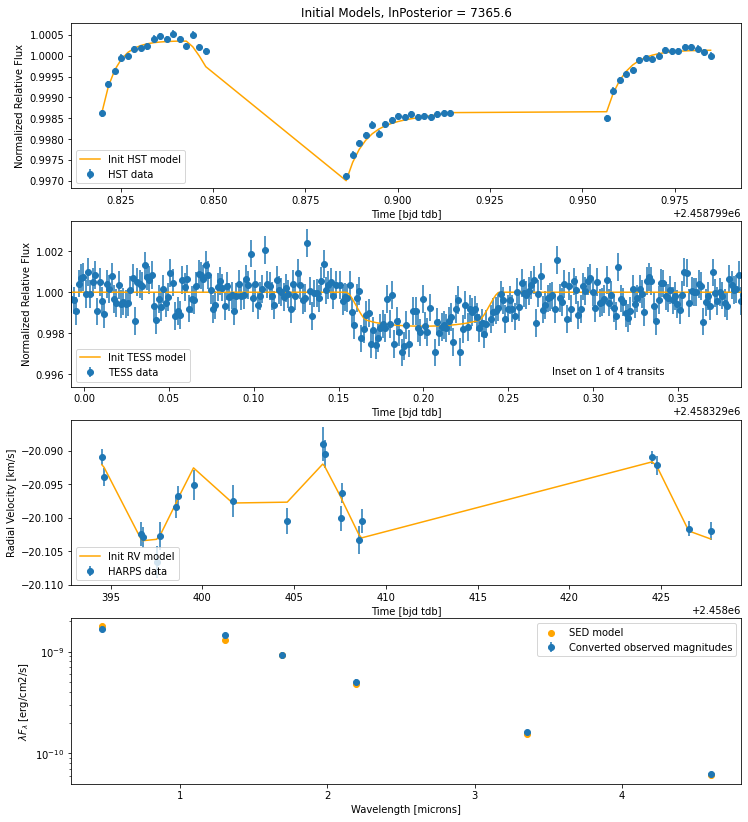

In [103]:
fig, ax = plt.subplots(nrows=4, figsize=(12,14))

ax[0].set_title('Initial Models, lnPosterior = %.1f'%(lnPosterior_initvalue))

ax[0].errorbar(t_bjdtdb_hst, flux_hst, errs_hst, ls='None', marker='o', label='HST data')
ax[0].plot(t_bjdtdb_hst, modelHST, color='orange', label='Init HST model')
ax[0].set_xlabel('Time [bjd tdb]')
ax[0].set_ylabel('Normalized Relative Flux')
ax[0].legend(loc='lower left')

ax[1].errorbar(t_bjdtdb_tess, flux_tess, errs_tess, ls='None', marker='o', label='TESS data')
ax[1].plot(t_bjdtdb_tess, modelTESS, color='orange', label='Init TESS model')
ax[1].text(t_bjdtdb_tess[200], 0.996, 'Inset on 1 of 4 transits')
ax[1].set_xlim(t_bjdtdb_tess[0], t_bjdtdb_tess[280])
ax[1].set_xlabel('Time [bjd tdb]')
ax[1].set_ylabel('Normalized Relative Flux')
ax[1].legend(loc='lower left')

ax[2].errorbar(t_bjdtdb_rv, vels_rv, errs_rv, ls='None', marker='o', label='HARPS data')
ax[2].plot(t_bjdtdb_rv, modelRV, color='orange', label='Init RV model')
ax[2].set_xlabel('Time [bjd tdb]')
ax[2].set_ylabel('Radial Velocity [km/s]')
ax[2].legend(loc='lower left')

ax[3].errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax[3].scatter(bandwavs_eff, modelSED, color='orange', label='SED model')
ax[3].set_yscale('log')
ax[3].set_xlabel('Wavelength [microns]')
ax[3].set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax[3].legend(loc='best');

In [105]:
######################################
# Setting up and initializing MCMC

Ndimensions = len(theta_init)
Nwalkers = 3*Ndimensions

# Initializing walker positions
pos = np.zeros((Nwalkers, Ndimensions))

for i in range(Ndimensions):
    pos[:,i] = theta_init[i] + 0.5*np.random.normal(0., priorserr[i], Nwalkers)
    
Nsteps = 9000
logParguments = [flux_hst, errs_hst, flux_tess, errs_tess, vels_rv, errs_rv, bandfluxes, bandfluxerrs,
                priors, priorserr,
                t_orbit_hst, t_bjdtdb_rv, sed_obs_dict, InterpFuncs, ExtinctionBase,
                tranmodel_hst_init, tranmodel_tess_init]



In [106]:
with Pool() as pool: 
    sampler = mc.EnsembleSampler(Nwalkers, Ndimensions, lnPosterior, args=logParguments, pool=pool)
    sampler.run_mcmc(pos, Nsteps, progress=True);

100%|██████████| 9000/9000 [18:12<00:00,  8.24it/s]


In [107]:
samples = sampler.get_chain()
flatsamples = sampler.get_chain(flat=True)
loglikelihoods = sampler.get_log_prob(flat=True)
#autocorrtimes = sampler.get_autocorr_time()

burn = 2000
samples = samples[burn:]
flatsamples = flatsamples[burn*Nwalkers:]
loglikelihoods = loglikelihoods[burn*Nwalkers:]

Text(0.5, 0, 'Steps')

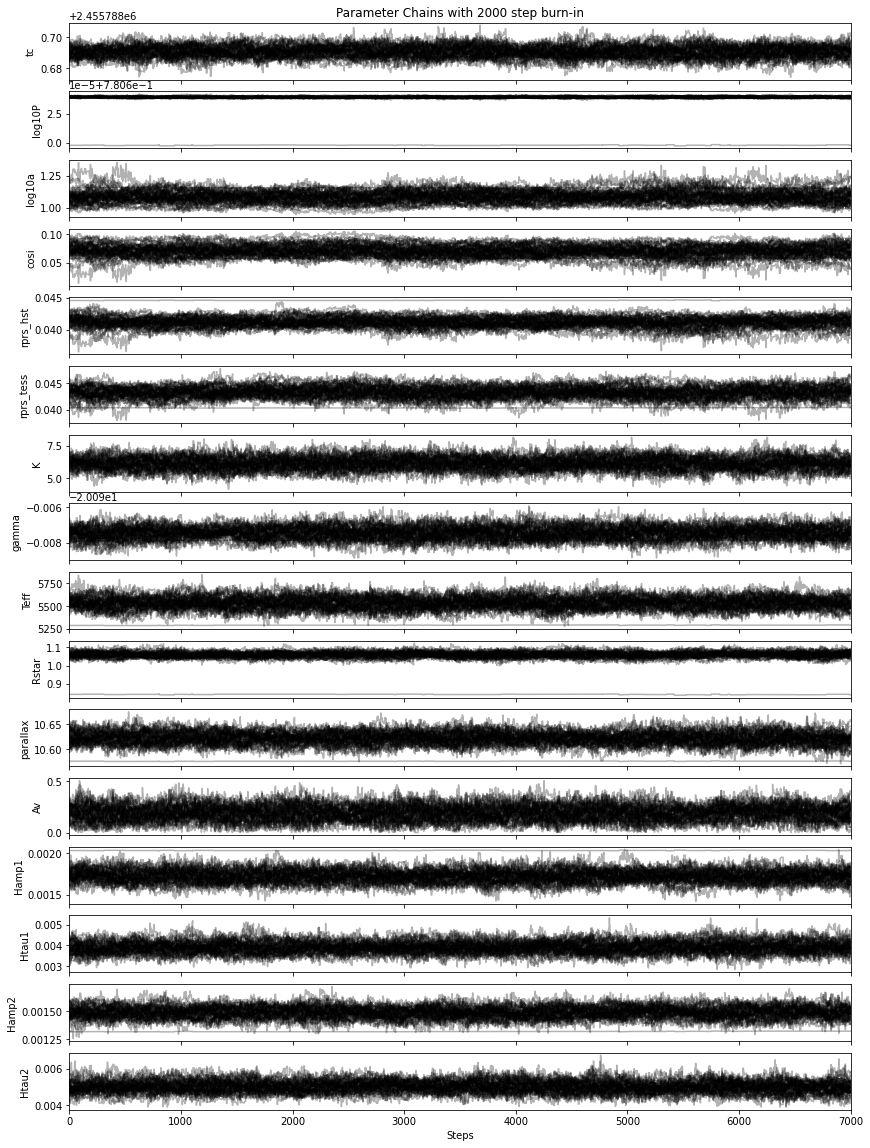

In [108]:
fig, axes = plt.subplots(samples.shape[2], figsize=(14,20), sharex=True)
for i in range(samples.shape[2]):
    ax = axes[i]
    ax.plot(samples[:,:,i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(param_labels[i])
axes[0].set_title('Parameter Chains with %d step burn-in'%burn)
axes[-1].set_xlabel('Steps')

In [109]:
param_fits = np.asarray([np.median(flatsamples[:,i]) for i in range(samples.shape[2])])
param_uperrs = np.asarray([np.percentile(flatsamples[:,i], 84) for i in range(samples.shape[2])]) - param_fits
param_loerrs = param_fits - np.asarray([np.percentile(flatsamples[:,i], 16) for i in range(samples.shape[2])])

param_fiterrs = np.asarray([])
for idx, val in enumerate(param_fits):
    param_fiterrs = np.append(param_fiterrs, np.mean([param_uperrs[idx], param_loerrs[idx]]))
    
# Computing derived quantities from the sample chains

def get_derived_values(valuechain):
    fitvalue = np.median(valuechain)
    fiterror = np.mean([(np.percentile(valuechain, 84) - fitvalue), (fitvalue - np.percentile(valuechain, 16))])
    return fitvalue, fiterror

# time of conjunction [day]
tc_chain = flatsamples[:,0]
fit_tc = param_fits[0]
fit_tc_err = param_fiterrs[0]

# orbital period [day]
log10P_chain = flatsamples[:,1]
P_chain = 10.**(log10P_chain)
fit_P, fit_P_err = get_derived_values(P_chain)

# semi-major axis [Rstar]
log10a_chain = flatsamples[:,2]
a_chain = 10.**(log10a_chain)
fit_a, fit_a_err = get_derived_values(a_chain)

# inclination [degrees]
cosi_chain = flatsamples[:,3]
inc_chain = np.arccos(cosi_chain)*(180./np.pi)
fit_inc, fit_inc_err = get_derived_values(inc_chain)

# rp/rstar in HST band 
rprstar_hst_chain = flatsamples[:,4]
fit_rprshst, fit_rprshst_err = get_derived_values(rprstar_hst_chain)

# transit depth in HST band 
depth_hst_chain = rprstar_hst_chain**2
fit_depthhst, fit_depthhst_err = get_derived_values(depth_hst_chain)

# rp/rstar in tess band 
rprstar_tess_chain = flatsamples[:,5]
fit_rprstess, fit_rprstess_err = get_derived_values(rprstar_tess_chain)

# transit depth in tess band [ppm]
depth_tess_chain = rprstar_tess_chain**2
fit_depthtess, fit_depthtess_err = get_derived_values(depth_tess_chain)

# RV semi-amplitude
K_chain = flatsamples[:,6]
fit_K, fit_K_err = get_derived_values(K_chain)

# RV system amplitude
gamma_chain = flatsamples[:,7]
fit_gamma, fit_gamma_err = get_derived_values(gamma_chain)

# Star effective temperature [K]
Teff_chain = flatsamples[:,8]
fit_Teff, fit_Teff_err = get_derived_values(Teff_chain)

# Star radius [Rsol]
Rstar_chain = flatsamples[:,9]
fit_Rstar, fit_Rstar_err = get_derived_values(Rstar_chain)

# Star density [rho_sol]
prefactor = (365.25**2)/(215.**3)
rhostar_chain = prefactor*(a_chain**3)/(P_chain**2)
fit_rhostar, fit_rhostar_err = get_derived_values(rhostar_chain)

# Star mass [Msol]
Mstar_chain = rhostar_chain*(Rstar_chain**3)
fit_Mstar, fit_Mstar_err = get_derived_values(Mstar_chain)

# Planet radius in HST band
rphst_chain = rprstar_hst_chain * Rstar_chain  # computes Rp in units [Rstar]
rphst_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rphst, fit_Rphst_err = get_derived_values(rphst_chain)

# Planet radius in tess band
rptess_chain = rprstar_tess_chain * Rstar_chain  # computes Rp in units [Rstar]
rptess_chain *= 109.076                         # converts Rp to units [Rearth]; 1 Rsun = 109.076 Rearth
fit_Rptess, fit_Rptess_err = get_derived_values(rptess_chain)

# Planet mass [Mearth]
G = 1.90809e5     # [Rsun * Msun^-1 * km^2/s^2]
k_kms = K_chain / 1000.         # converts to [km/s]
a_rsun = a_chain * Rstar_chain  # converts to [Rsol]
sini = np.sin(inc_chain*(np.pi/180.))
ecc_chain = 0.
Mp_chain = (k_kms / sini)*np.sqrt((a_rsun*(1. - ecc_chain**2))/G)*np.sqrt(Mstar_chain)  # computes Mp in units [Msun]
Mp_chain *= 332946.0487         # converts Mp to units [Mearth]
fit_Mp, fit_Mp_err = get_derived_values(Mp_chain)


# Parallax [mas]
plx_chain = flatsamples[:,10]
fit_plx, fit_plx_err = get_derived_values(plx_chain)

# V band extinction [mag]
Av_chain = flatsamples[:,11]
fit_Av, fit_Av_err = get_derived_values(Av_chain)

deriv_fits = np.asarray([fit_tc, fit_P, fit_a, fit_inc,  
                         fit_depthhst, fit_depthtess, fit_Rphst, fit_Rptess, fit_Mp,
                         fit_K, fit_gamma,
                         fit_Teff, fit_Rstar, fit_Mstar, fit_plx, fit_Av])

deriv_fiterrs = np.asarray([fit_tc_err, fit_P_err, fit_a_err, fit_inc_err,  
                            fit_depthhst_err, fit_depthtess_err, fit_Rphst_err, fit_Rptess_err, fit_Mp_err,
                            fit_K_err, fit_gamma_err,
                            fit_Teff_err, fit_Rstar_err, fit_Mstar_err, fit_plx_err, fit_Av_err])

deriv_labels = np.asarray(['Tc [day]', 'P [day]', 'a [Rstar]', 'inc [deg]', 
                          'HST depth', 'TESS depth', 'HST Rp [Rearth]', 'TESS Rp [Rearth]', 'Mp [Mearth]',
                           'K [m/s]', 'gamma [km/s]', 
                          'Teff [K]', 'Rstar [Rsol]', 'Mstar [Msol]', 'parallax [mas]', 'Av [mag]'])

In [110]:
# Setting up table of parameter fit values
from tabulate import tabulate
l = []
headers = np.asarray(['Parameter', 'Median Value', 'Uncertainty', 'Initial (Literature) Value'])
for i, val in enumerate(param_labels):
    new = [param_labels[i], param_fits[i], param_fiterrs[i], theta_init[i]]
    l.append(new)
table_params = tabulate(l, headers, tablefmt='pretty')

l = []
headers = np.asarray(['Quantity', 'Median Value', 'Mean Uncertainty', 'Literature/Initial Value', 'Literature Uncertainty'])
for i, val in enumerate(deriv_labels):
    new = [deriv_labels[i], deriv_fits[i], deriv_fiterrs[i], deriv_lit[i], deriv_lit_errs[i]]
    l.append(new)
table_derived = tabulate(l, headers, tablefmt='pretty')

print("Fitting Parameters")
print(table_params)
print(' ')
print("Derived System Quantities")
print(table_derived)

Fitting Parameters
+-----------+-----------------------+-----------------------+----------------------------+
| Parameter |     Median Value      |      Uncertainty      | Initial (Literature) Value |
+-----------+-----------------------+-----------------------+----------------------------+
|    tc     |   2455788.690599061   | 0.0036319000646471977 |       2455788.69194        |
|  log10P   |  0.7806391214565892   |  6.414459177706e-07   |     0.7806384128736322     |
|  log10a   |  1.0855409858760523   |  0.04799236920384198  |     1.1228709228644356     |
|   cosi    |  0.07055015207484291  | 0.010537644233627255  |    0.06313889274550116     |
| rprs_hst  |  0.04122402498631051  | 0.0007965472369039321 |          0.04192           |
| rprs_tess | 0.043265463230268406  | 0.0010979766252392949 |          0.04192           |
|     K     |  6.1420861874962185   |  0.46751550288005905  |            6.17            |
|   gamma   |  -20.097457969688545  | 0.0003574489854489826 |          

In [323]:
#fig = corner.corner(flatsamples, labels=param_labels, show_titles=False);



In [111]:
##########################################
# Computing best fit models & de-trended data & residuals

# HST broadband
fitmodelHST = model_HSTbroadband(param_fits, t_orbit_hst, tranmodel_hst_init)
fittransitHST = transit(param_fits, tranmodel_hst_init, telescope='hst')
fithook_HST = hook(param_fits, t_orbit_hst)

dtflux_hst = flux_hst / fithook_HST
dterrs_hst = errs_hst / fithook_HST

residuals_hst = flux_hst - fitmodelHST
residual_std_hst = np.std(residuals_hst)
meanerror_hst = np.mean(errs_hst)

BFHSTtransitParams = batman.TransitParams()
BFHSTtransitParams.t0 = fit_tc        
BFHSTtransitParams.per = fit_P
BFHSTtransitParams.rp = fit_rprshst
BFHSTtransitParams.a = fit_a
BFHSTtransitParams.inc = fit_inc
BFHSTtransitParams.ecc = 0.
BFHSTtransitParams.w = 90.
BFHSTtransitParams.limb_dark = 'quadratic'
BFHSTtransitParams.u = [0.33, 0.2]

fitpresent_hst_times = np.linspace(t_bjdtdb_hst[0], t_bjdtdb_hst[-1], 100)
fittranmodel_hst_init = batman.TransitModel(BFHSTtransitParams, fitpresent_hst_times)
fitpresent_hst_model = fittranmodel_hst_init.light_curve(BFHSTtransitParams)

# TESS
fitmodelTESS = model_TESS(param_fits, tranmodel_tess_init)

residuals_tess = flux_tess - fitmodelTESS
residual_std_tess = np.std(residuals_tess)
meanerror_tess = np.mean(errs_tess)

#fitpresent_tess_times = np.linspace(fit_tc-0.75*fit_P, fit_tc+0.75*fit_P, 100)
pfphases_tess = phasefold(t_bjdtdb_tess, fit_tc, fit_P)
# it splits them weirdly, for some reason
pfphases_tess_correct = np.copy(pfphases_tess)
pfphases_tess_correct[np.where(pfphases_tess > 0.5)[0]] -= 1.

tesssort = np.argsort(pfphases_tess_correct)
fitpresent_tess_pfphases = pfphases_tess_correct[tesssort]
fitpresent_tess_pfmodel = fitmodelTESS[tesssort]


# HARPS RV
rv_phases = phasefold(t_bjdtdb_rv, fit_tc, fit_P)
fitmodelRV = model_HARPSRV(param_fits, t_bjdtdb_rv)

residuals_rv = vels_rv - fitmodelRV
residual_std_rv = np.std(residuals_rv)
meanerror_rv = np.mean(errs_rv)

fitpresent_rv_pftimes = np.linspace(fit_tc, fit_tc + fit_P - 1.e-5, 100)
fitpresent_rv_pfphases = phasefold(fitpresent_rv_pftimes, fit_tc, fit_P)
fitpresent_rv_pfmodel = radial_velocity(param_fits, fitpresent_rv_pftimes)

# Stellar SED
fitmodelSED = model_SED(param_fits, sed_obs_dict, InterpFuncs, ExtinctionBase)

residuals_sed = bandfluxes - fitmodelSED
residual_std_sed = np.std(residuals_sed)
meanerror_sed = np.mean(bandfluxerrs)
    
# Computing ln Posterior of best fit parameter array
lnPosterior_fitvalue = lnPosterior(param_fits,
                                    flux_hst, errs_hst, flux_tess, errs_tess, vels_rv, errs_rv, bandfluxes, bandfluxerrs,
                                    priors, priorserr,
                                    t_orbit_hst, t_bjdtdb_rv, sed_obs_dict, InterpFuncs, ExtinctionBase,
                                    tranmodel_hst_init, tranmodel_tess_init)

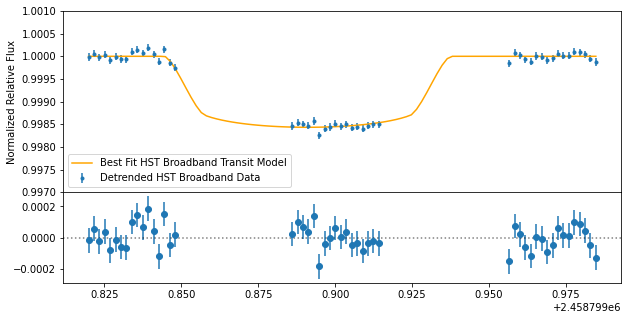

In [112]:
gridspec = dict(hspace=0., height_ratios=[1,0.5])
fig, ax = plt.subplots(nrows=2, figsize=(10,5), gridspec_kw=gridspec, sharex=True)
#fig.subplots_adjust(hspace=0)

ax[0].errorbar(t_bjdtdb_hst, dtflux_hst, dterrs_hst, ls='None', marker='o', ms=3, label='Detrended HST Broadband Data')
ax[0].plot(fitpresent_hst_times, fitpresent_hst_model, color='orange', label='Best Fit HST Broadband Transit Model')
ax[0].set_ylim(0.997, 1.001)
ax[0].set_xlabel('Time [bjd tdb]')
ax[0].set_ylabel('Normalized Relative Flux')
ax[0].legend(loc='lower left')

ax[1].errorbar(t_bjdtdb_hst, residuals_hst, dterrs_hst, ls='None', marker='o')
ax[1].axhline(0., ls='dotted', color='black', alpha=0.5)

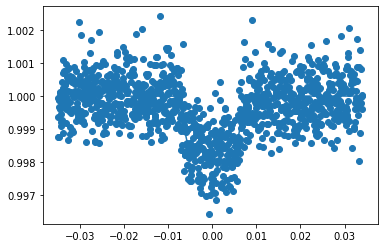

In [113]:
plt.scatter(pfphases_tess_correct, flux_tess)
plt.plot(fitpresent_tess_pfphases, fitpresent_tess_pfmodel)
#plt.xlim((0.9, 1.1))

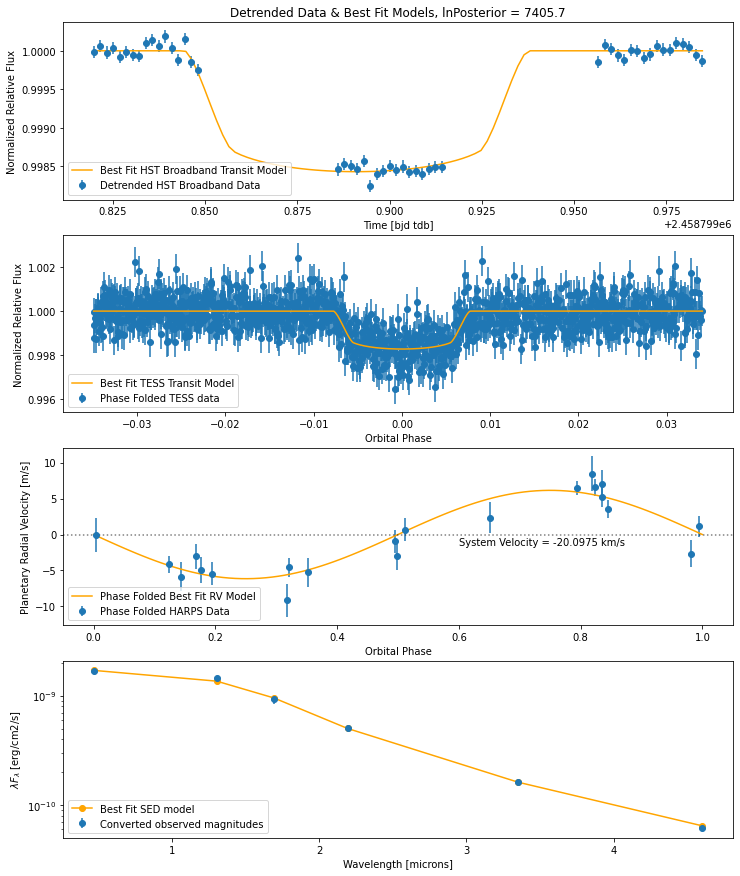

In [114]:
fig, ax = plt.subplots(nrows=4, figsize=(12,15))

ax[0].set_title('Detrended Data & Best Fit Models, lnPosterior = %.1f'%(lnPosterior_fitvalue))

ax[0].errorbar(t_bjdtdb_hst, dtflux_hst, dterrs_hst, ls='None', marker='o', label='Detrended HST Broadband Data')
ax[0].plot(fitpresent_hst_times, fitpresent_hst_model, color='orange', label='Best Fit HST Broadband Transit Model')
ax[0].set_xlabel('Time [bjd tdb]')
ax[0].set_ylabel('Normalized Relative Flux')
ax[0].legend(loc='lower left')

ax[1].errorbar(pfphases_tess_correct, flux_tess, errs_tess, ls='None', marker='o', label='Phase Folded TESS data')
ax[1].plot(fitpresent_tess_pfphases, fitpresent_tess_pfmodel, color='orange', zorder=5, label='Best Fit TESS Transit Model')
#ax[1].errorbar(t_bjdtdb_tess, flux_tess, errs_tess, ls='None', marker='o', label='TESS data')
#ax[1].plot(t_bjdtdb_tess, fitmodelTESS, color='orange', label='Best Fit TESS Transit Model')
#ax[1].text(t_bjdtdb_tess[200], 0.996, 'Inset on 1 of 4 transits')
#ax[1].set_xlim(t_bjdtdb_tess[0], t_bjdtdb_tess[280])
ax[1].set_xlabel('Orbital Phase')
ax[1].set_ylabel('Normalized Relative Flux')
ax[1].legend(loc='lower left')

ax[2].errorbar(rv_phases, (vels_rv - fit_gamma)*1000., errs_rv*1000, ls='None', marker='o', label='Phase Folded HARPS Data')
ax[2].plot(fitpresent_rv_pfphases, (fitpresent_rv_pfmodel - fit_gamma)*1000., color='orange', label='Phase Folded Best Fit RV Model')
ax[2].axhline(0., ls='dotted', color='black', alpha=0.5)
ax[2].text(0.6, -1.5, 'System Velocity = %.4f km/s'%(fit_gamma))
ax[2].set_xlabel('Orbital Phase')
ax[2].set_ylabel('Planetary Radial Velocity [m/s]')
ax[2].legend(loc='lower left')

ax[3].errorbar(bandwavs_eff, bandfluxes, bandfluxerrs, ls='None', marker='o', label='Converted observed magnitudes')
ax[3].plot(bandwavs_eff, fitmodelSED, color='orange', marker='o', label='Best Fit SED model')
ax[3].set_yscale('log')
ax[3].set_xlabel('Wavelength [microns]')
ax[3].set_ylabel(r'$\lambda F_\lambda$ [erg/cm2/s]')
ax[3].legend(loc='lower left');

In [115]:
print('Residual Statistics')
resid_table_labels = np.asarray(['HST Broadband [ppm]', 'TESS [ppm]', 'HARPS RV [m/s]', 'SED [erg/cm2/s]'])
resid_stdvals = np.asarray([residual_std_hst*1.e6, residual_std_tess*1.e6, residual_std_rv*1.e3, residual_std_sed])
meanerrvals = np.asarray([meanerror_hst*1.e6, meanerror_tess*1.e6, meanerror_rv*1.e3, meanerror_sed])

l = []
headers = np.asarray(['Set', 'Residual Standard Deviation', 'Mean Data Uncertainty', 'Ratio'])
for i, val in enumerate(resid_table_labels):
    l.append([resid_table_labels[i], resid_stdvals[i], meanerrvals[i], resid_stdvals[i]/meanerrvals[i]])
table_residstats = tabulate(l, headers, tablefmt='pretty')

print(table_residstats)

Residual Statistics
+---------------------+-----------------------------+------------------------+--------------------+
|         Set         | Residual Standard Deviation | Mean Data Uncertainty  |       Ratio        |
+---------------------+-----------------------------+------------------------+--------------------+
| HST Broadband [ppm] |      78.92791962179894      |     78.50111830768     | 1.0054368819619373 |
|     TESS [ppm]      |      676.0151923177845      |   676.3283163309097    | 0.9995370236532104 |
|   HARPS RV [m/s]    |      1.73372461467321       |   1.733999502384386    | 0.9998414718627093 |
|   SED [erg/cm2/s]   |    4.63862973396473e-11     | 4.6884103271930477e-11 | 0.9893822021209221 |
+---------------------+-----------------------------+------------------------+--------------------+
